<a href="https://colab.research.google.com/github/sdw1621/tensorflow_hangi_uni/blob/main/Convolutional_VAE_Fashion_MNIST_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fashion MNIST Convolutional VAE 모델

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Fashion MNIST Datset 불러오기

(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
all_data = np.concatenate([x_train, x_test], axis=0)
all_data = np.expand_dims(all_data, -1).astype("float32") / 255


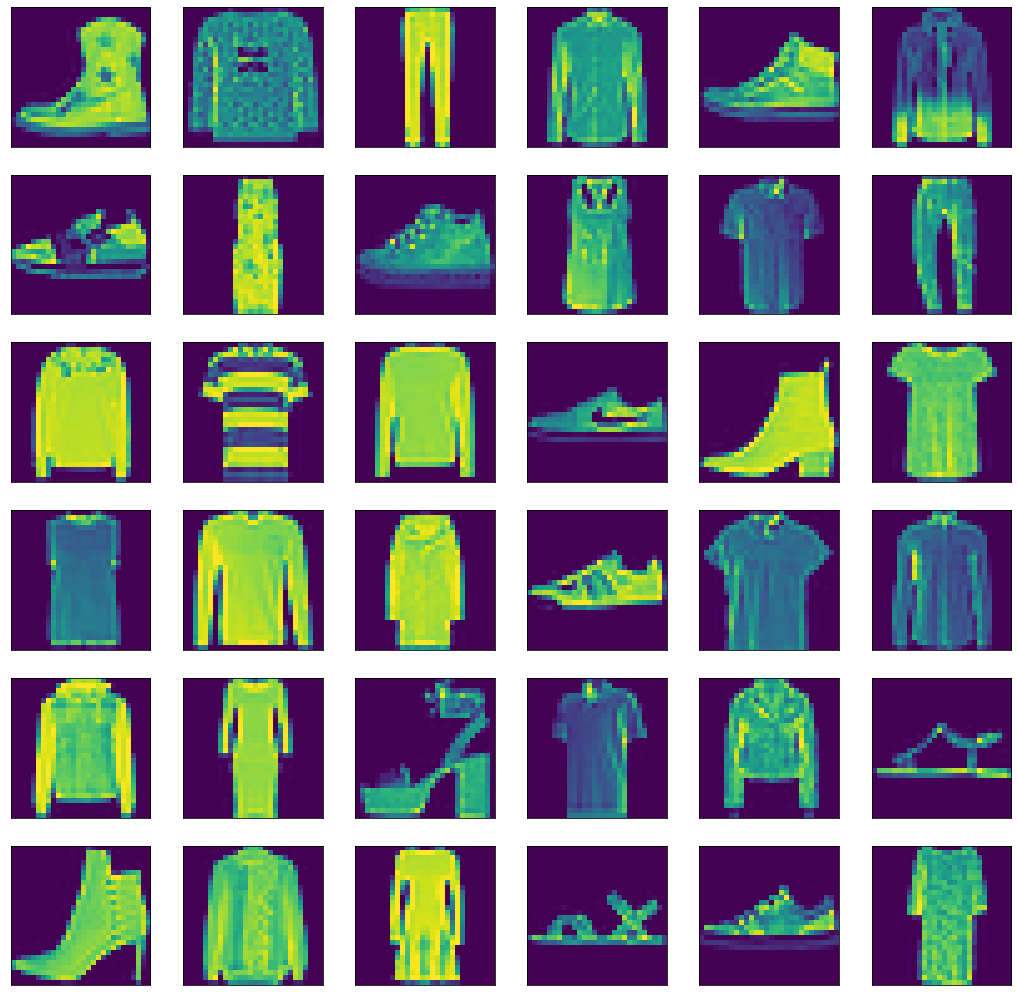

In [ ]:
# FASHION MINST 보기
import numpy as np
import matplotlib.pyplot as plt

# plot 18" x 18" 
fig = plt.figure(figsize=(18, 18))
for idx in range(36):
    id = np.random.randint(60000)
    number = fig.add_subplot(6, 6, idx+1, xticks=[], yticks=[])
    number.imshow(np.squeeze(all_data[id]))#, cmap='gray')


In [ ]:
# Reprameterization

class reparam(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# latent dim은 평균과 표준편차 각각 해당  
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = reparam()([z_mean, z_log_var])

# z_mean = [batch, dim], z_log_var = [batch, dim]
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 32)   320         ['input_9[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_8[0][0]']               
                                                                                                  
 flatten_4 (Flatten)            (None, 3136)         0           ['conv2d_9[0][0]']               
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 28, 28, 1)        289 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # 복원된 결과 = 입력된 데이터가 되도록 학습
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum( keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2) )
            )

            # KLD를 이용하여 latent의 분포가 정규분포 형태로 만들기
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # 최종 목적함수
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# VAE 학습

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(all_data, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 12s 19ms/step - loss: 386.3025 - reconstruction_loss: 327.5426 - kl_loss: 7.3280
Epoch 2/10
547/547 [==============================] - 10s 19ms/step - loss: 283.3700 - reconstruction_loss: 272.3621 - kl_loss: 8.1123
Epoch 3/10
547/547 [==============================] - 10s 19ms/step - loss: 275.5479 - reconstruction_loss: 266.9771 - kl_loss: 7.5782
Epoch 4/10
547/547 [==============================] - 10s 19ms/step - loss: 272.7664 - reconstruction_loss: 264.7618 - kl_loss: 7.5226
Epoch 5/10
547/547 [==============================] - 10s 19ms/step - loss: 270.9776 - reconstruction_loss: 263.2208 - kl_loss: 7.4662
Epoch 6/10
547/547 [==============================] - 10s 19ms/step - loss: 269.4648 - reconstruction_loss: 262.2219 - kl_loss: 7.4422
Epoch 7/10
547/547 [==============================] - 10s 19ms/step - loss: 268.9420 - reconstruction_loss: 261.2069 - kl_loss: 7.4253
Epoch 8/10
547/547 [==============================] - 1

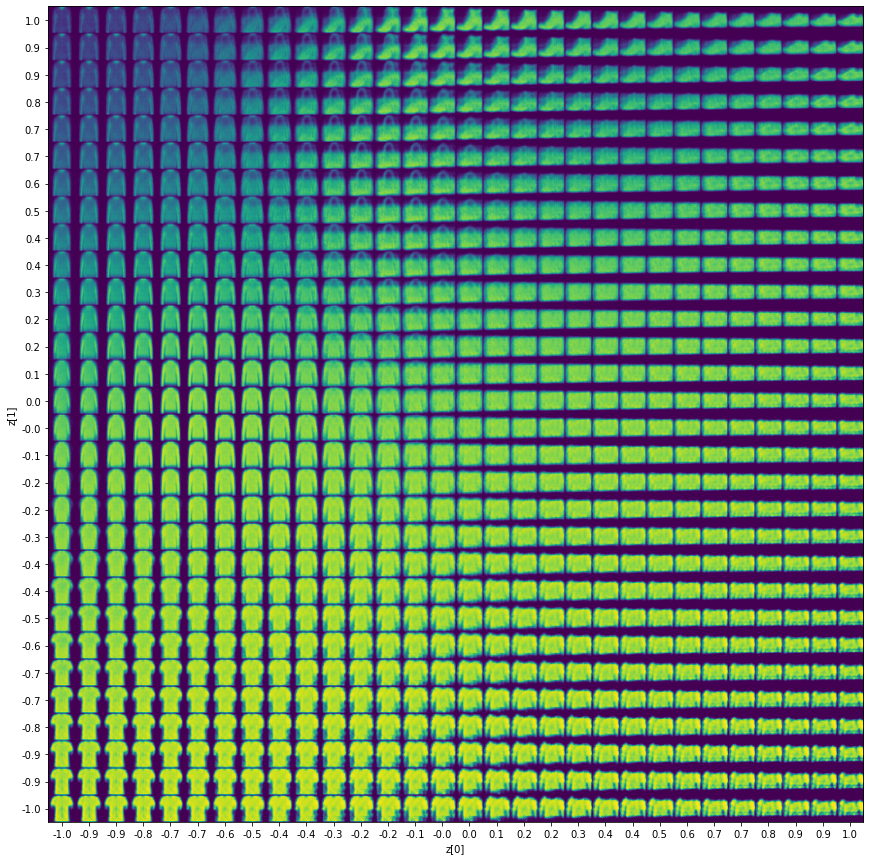

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(vae)

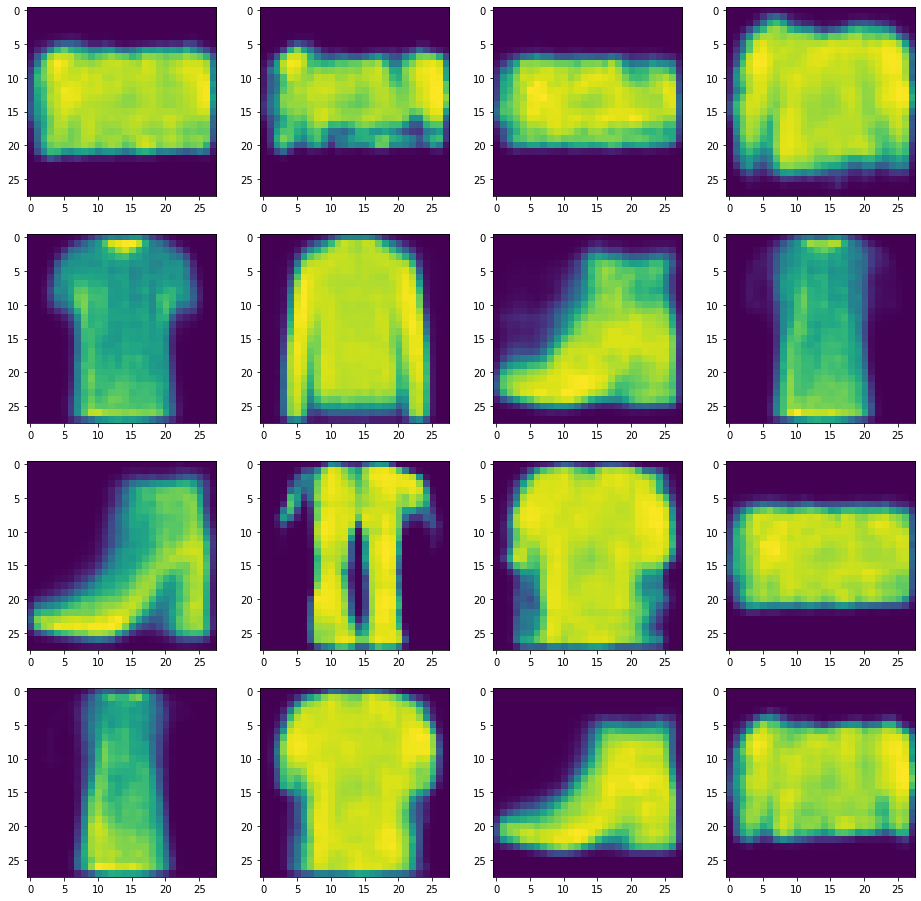

In [ ]:
# 임의의 latent 값으로 생성해보기

fig = plt.figure(figsize=(16, 16))
for idx in np.arange(16):
    latent = np.random.randn(1,2)
    image = vae.decoder.predict(latent)
    sub_plot = fig.add_subplot(4,4, idx+1)
    sub_plot.imshow(np.squeeze(image)) #, cmap='gray')

